## 실제 데이터 셋에 접목 : iris dataset 분류 

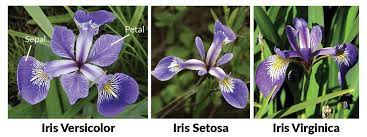

## Torch를 좀 더 잘 활용하기!

### python의 class 를 잘 알면 유리하다!



- torch.utils.data.Dataset
- torch.utils.data.DatLoader

( + torch.utils.data.Sampler : 배치 구성 방법 정의)  

Dataset을 통해서 data를 정의하고,  
Dataloader를 통해서 배치 iteration 을 손쉽게 함  

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.datasets import load_iris
import numpy as np

In [2]:
# 연산 방법 
'''
    cpu: 복잡한 일 + 느림
    gpu: 단순한 일 + 빠름
    pytorch를 이용해서 gpu 연산이 가능해짐
    colab에서 무료로 gpu 제공!

    단, gpu 연산 시,
    계산에 필요한 모든 variable/함수를 .to(device)를 이용해 gpu로 옮겨놔야 한다! 
'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

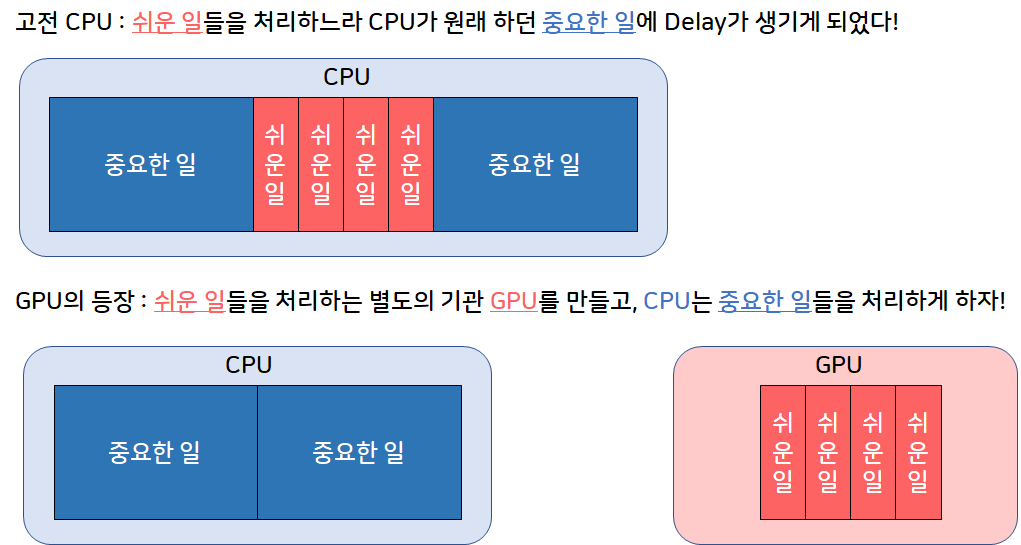

In [3]:
import torch
from torch import nn, optim
from sklearn.datasets import load_iris
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = load_iris()

input = iris.data
output = iris.target

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.33, random_state=42,stratify=iris.target,shuffle = True)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 => 공식 사이트 자주 확인하기ㅠㅠ 
# X_train = torch.FloatTensor(X_train).to(device)
# y_train = torch.LongTensor(y_train).to(device)
# X_test = torch.FloatTensor(X_test)
# y_test = torch.LongTensor(y_test)

In [4]:
print(y_train)

[2 0 2 1 0 0 0 2 0 0 1 0 1 1 2 2 0 0 2 0 2 0 0 2 0 1 2 1 0 1 0 2 1 2 1 0 2
 0 2 0 1 1 0 2 1 1 0 2 1 2 0 1 0 2 1 1 1 1 1 1 2 1 2 2 0 2 1 1 2 0 2 2 2 0
 2 0 0 2 2 2 0 1 2 2 0 1 1 1 1 1 0 2 1 2 0 0 1 0 1 0]


In [5]:
print(X_train[0])
print(y_train[0])

[6.3 3.4 5.6 2.4]
2


input 변수가 4개!  
y의 class 종류가 3개!

# Custom Dataset을 정의하고 싶다면 3가지를 기억하자!!  


- __init__ : class 에서 객체가 생성되면 바로 실행되는 함수  
- __len__ : observation 수를 정의하는 함수 
- __getitem__ : iteration 마다 해당하는 데이터를 돌려주는 함수

In [6]:
class CustomDataset(Dataset):
  def __init__(self):
    
    self.x_data = X_train
    self.y_data = [[y] for y in y_train]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x,y

In [7]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) #sampler를 만들었다면, sampler를 파라미터로 넣어줄 수 있음 : https://hyelimkungkung.tistory.com/29?category=935193 참고 ㅎㅎ

## Model 역시 class 로 구현이 가능하다!

- __init__ : 초기 생성 함수
- __foward__ : 순전파(입력값 => 예측값 의 과정)


In [8]:
 model = nn.Sequential(
          nn.Linear(4, 50, bias=True), # input_layer = 2, hidden_layer1 = 10 
          nn.Sigmoid(),
          nn.Linear(50, 50, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
          nn.Sigmoid(),
          nn.Linear(50, 3, bias=True), # hidden_layer3 = 10, output_layer = 1
          nn.Softmax()
          ).to(device)

In [9]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4, 50, bias=True), # input_layer = 2, hidden_layer1 = 10 
          nn.Sigmoid(),

  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징
        nn.BatchNorm1d(50)

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 


    )
    self.layer2 = nn.Sequential(
          nn.Linear(50, 50, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(50, 50, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(50, 3, bias=True), # hidden_layer3 = 10, output_layer = 1
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

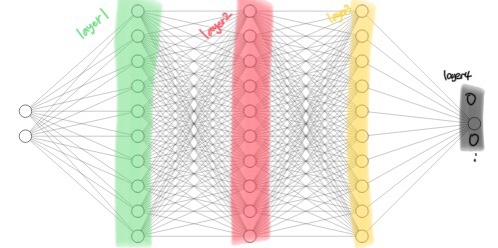

In [10]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [11]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [12]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


In [13]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# Adam 등등 

In [14]:
losses = []
for epoch in range(100):

  for x, y in dataloader:
    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    # forward 연산
    hypothesis = model(x)

    # 비용 함수
    y = y.squeeze()
    cost = loss(hypothesis, y)
    cost.backward()
    optimizer.step()
  losses.append(cost.item()) # 값만 가져오기 위해서 .item()

  # 10의 배수에 해당되는 에포크마다 비용을 출력
  if epoch % 10 == 0:
      print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.150328516960144
10 0.9880949854850769
20 0.8944395780563354
30 0.8631263971328735
40 0.8396452069282532
50 0.8312774896621704
60 0.826806366443634
70 0.8218287229537964
80 0.8181469440460205
90 0.8154104948043823


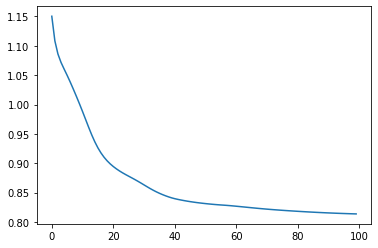

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [16]:
with torch.no_grad():

    model = model.to('cpu')
    X_test = torch.FloatTensor(X_test)
    y_pred = model(X_test)

    y_pred = y_pred.detach().numpy() # tensor를 numpy로 바꿈
    predicted = np.argmax(y_pred,axis=1)
    print(f'model의 output은 :  {y_pred[0]}' )
    print(f'argmax를 한 후의 output은 {predicted[0]}')
    accuracy = (accuracy_score(predicted,y_test))
    print(f'accuracy는 {accuracy}')

model의 output은 :  [2.7476874e-04 7.7973300e-01 2.1999221e-01]
argmax를 한 후의 output은 1
accuracy는 0.84


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## 다음주 과제 

 - 저번주에 진행했던 분석을 오늘 배운 것들 위주로 고쳐보기



---



 - 형식/ 제출 방식

  제출은 github에 다음주 화 - 수요일까지 해주세요!   
https://github.com/KU-BIG/KUBIG_2022_Spring/tree/main/%EB%B0%A9%ED%95%99%EB%B6%84%EB%B0%98/DL/2%EC%A3%BC%EC%B0%A8 
  3주차 폴더 안에! 3주차_ 혜림 


> (필수) 데이터 분석 목표, auc, 기존 코드에서 바꿔본 내용(upload할 때 description에 달아주세요) +  코드 (옵션)질문사항



---

- 발표

 제출된 것들 중   
  (1) auc가 높은 것   
  (2) 흥미로운 시도  
기준으로 3 건을 뽑아서 발표하도록 하겠습니다!  모두가 업로드 한 시점으로부터 최대한 빠르게 발표할 사람을 알려드리도록 할께요!   
발표는 위에서 필수 사항 + 코드 로 중심으로 간단하게 해주시면 됩니다 기타 발표 자료는 추가 사항입니다 



하다가 질문 생기면 편하게 말씀해주세요~  



